In [53]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Forecasting
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Robust date parsing
from dateutil import parser

# Inline plots
%matplotlib inline

In [54]:
#Load Dataset

# Load CSV
data = pd.read_csv("../data/OnlineRetailDataSet.csv", encoding='utf-8-sig')

# Quick overview
print(data.head())
print(data.info())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  1/12/2010 8:26       2.55     17850.0  United Kingdom  
1  1/12/2010 8:26       3.39     17850.0  United Kingdom  
2  1/12/2010 8:26       2.75     17850.0  United Kingdom  
3  1/12/2010 8:26       3.39     17850.0  United Kingdom  
4  1/12/2010 8:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo   

## Data Cleaning


In [58]:


# Convert InvoiceDate to datetime safely
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], dayfirst=True, errors='coerce')

# Drop invalid dates
data = data.dropna(subset=['InvoiceDate'])

# Remove cancelled orders (InvoiceNo starting with 'C')
data = data[~data['InvoiceNo'].str.startswith('C')]

# Drop rows with missing CustomerID
data = data.dropna(subset=['CustomerID'])

# Add TotalPrice column
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']



# Check shape
data.shape


(168649, 9)

In [59]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## Customer Aggregation


In [60]:
# Aggregate per customer
customer_data = data.groupby('CustomerID').agg({
    'TotalPrice': 'sum',
    'InvoiceNo': 'nunique',
    'Quantity': 'sum'
}).rename(columns={'TotalPrice': 'TotalSpent',
                   'InvoiceNo': 'NumOrders',
                   'Quantity': 'TotalQuantity'})

customer_data.head()


,TotalSpent,NumOrders,TotalQuantity
CustomerID,,,
12347.0,2540.29,5,1467
12348.0,367.00,1,269
12350.0,334.40,1,197
12352.0,1296.38,3,156
12355.0,459.40,1,240


## Customer Segmentation (KMeans)


In [61]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_data)

# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
customer_data['Cluster'] = kmeans.fit_predict(X_scaled)

customer_data.head()


,TotalSpent,NumOrders,TotalQuantity,Cluster
CustomerID,,,,
12347.0,2540.29,5,1467,0
12348.0,367.00,1,269,0
12350.0,334.40,1,197,0
12352.0,1296.38,3,156,0
12355.0,459.40,1,240,0


## Cluster Summary


In [62]:
# Check cluster sizes and profiles
cluster_summary = customer_data.groupby('Cluster').agg({
    'TotalSpent':'mean',
    'NumOrders':'mean',
    'TotalQuantity':'mean',
    'Cluster':'count'
}).rename(columns={'Cluster':'NumCustomers'})

cluster_summary


,TotalSpent,NumOrders,TotalQuantity,NumCustomers
Cluster,,,,
0,662.023295,1.889334,392.131416,2747
1,130680.010000,19.333333,60511.666667,3
2,4846.482957,9.504348,2589.386957,230
3,32363.464118,31.058824,20702.411765,17


## Cluster Visualization


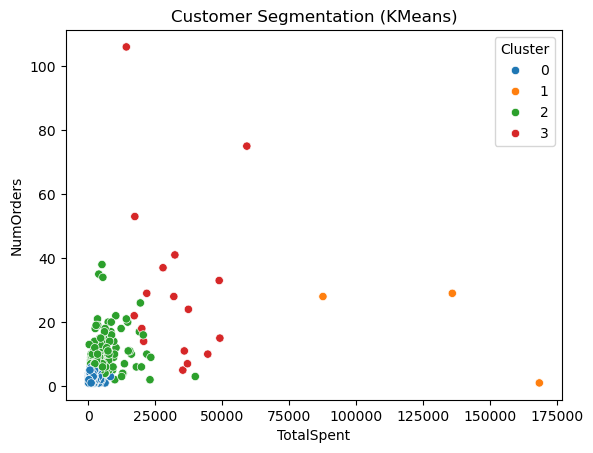

In [63]:
# Visualize clusters (using TotalSpent vs NumOrders)
sns.scatterplot(data=customer_data, x='TotalSpent', y='NumOrders', hue='Cluster', palette='tab10')
plt.title("Customer Segmentation (KMeans)")
plt.savefig("../visuals/customer_clusters.png", dpi=150)
plt.show()
